# MVP and HRP Portfolio Design for FMCG Sector Stocks 

## 1. Loading the Data and Python Libraries

### 1.1. Loading the Python Libraries 

In [32]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


### 1.2. Loading the Data 

In [33]:
# load dataset
dataset = read_csv('fmcg.csv',index_col=0)

In [34]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [35]:
type(dataset)

pandas.core.frame.DataFrame

## 2. Exploratory Data Analysis 

In [36]:
# shape
dataset.shape

(1482, 10)

In [37]:
# peek at data
set_option('display.width', 100)
dataset.head()

HINDUNILVR         ITC    NESTLEIND  TATACONSUM    BRITANNIA    GODREJCP       DABUR  \
date                                                                                               
01-01-2016  856.549988  218.333328  5785.149902  146.399994  1493.199951  447.350006  276.399994   
04-01-2016  859.000000  216.733337  5669.799805  143.699997  1486.300049  443.250000  276.899994   
05-01-2016  847.950012  216.566666  5662.399902  148.350006  1483.349976  438.633331  275.950012   
06-01-2016  843.049988  210.066666  5719.500000  145.250000  1500.849976  435.383331  275.899994   
07-01-2016  820.250000  206.399994  5638.950195  140.050003  1473.275024  420.299988  267.700012   

            MCDOWELL-N      MARICO      COLPAL  
date                                            
01-01-2016  602.099976  227.149994  976.750000  
04-01-2016  595.489990  225.300003  974.299988  
05-01-2016  589.000000  229.649994  974.250000  
06-01-2016  579.729981  226.850006  949.450012  
07-01-2016  556.460022  223.699997  915.549988

## 3. Data Pre-processing

### 3.1. Data Cleaning

In [38]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = False


(1482, 10)

Getting rid of the columns with more than 30% missing values. 

In [39]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.4].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1482, 10)

Given that there are null values drop the rown contianing the null values.

In [40]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

HINDUNILVR         ITC    NESTLEIND  TATACONSUM    BRITANNIA    GODREJCP       DABUR  \
date                                                                                               
01-01-2016  856.549988  218.333328  5785.149902  146.399994  1493.199951  447.350006  276.399994   
04-01-2016  859.000000  216.733337  5669.799805  143.699997  1486.300049  443.250000  276.899994   
05-01-2016  847.950012  216.566666  5662.399902  148.350006  1483.349976  438.633331  275.950012   
06-01-2016  843.049988  210.066666  5719.500000  145.250000  1500.849976  435.383331  275.899994   
07-01-2016  820.250000  206.399994  5638.950195  140.050003  1473.275024  420.299988  267.700012   

            MCDOWELL-N      MARICO      COLPAL  
date                                            
01-01-2016  602.099976  227.149994  976.750000  
04-01-2016  595.489990  225.300003  974.299988  
05-01-2016  589.000000  229.649994  974.250000  
06-01-2016  579.729981  226.850006  949.450012  
07-01-2016  556.460022  223.699997  915.549988

### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.30% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [44]:
X= dataset.copy('deep')
row= len(X)
# train_len = int(row*.8)
train_len = int(row*.8330)

In [45]:
X_train = X.head(train_len)

In [46]:
X_train

HINDUNILVR         ITC     NESTLEIND  TATACONSUM    BRITANNIA    GODREJCP  \
date                                                                                     
01-01-2016   856.549988  218.333328   5785.149902  146.399994  1493.199951  447.350006   
04-01-2016   859.000000  216.733337   5669.799805  143.699997  1486.300049  443.250000   
05-01-2016   847.950012  216.566666   5662.399902  148.350006  1483.349976  438.633331   
06-01-2016   843.049988  210.066666   5719.500000  145.250000  1500.849976  435.383331   
07-01-2016   820.250000  206.399994   5638.950195  140.050003  1473.275024  420.299988   
...                 ...         ...           ...         ...          ...         ...   
24-12-2020  2402.250000  208.600006  18566.349610  601.000000  3618.250000  721.000000   
28-12-2020  2388.899902  209.500000  18597.349610  602.450012  3603.550049  727.250000   
29-12-2020  2384.300049  211.550003  18262.650390  598.599976  3593.300049  741.150024   
30-12-2020  2406.600098  211.149994  18379.250000  594.349976  3583.899902  749.150024   
31-12-2020  2395.399902  209.000000  18390.250000  589.900024  3576.350098  740.150024   

                 DABUR  MCDOWELL-N      MARICO       COLPAL  
date                                                         
01-01-2016  276.399994  602.099976  227.149994   976.750000  
04-01-2016  276.899994  595.489990  225.300003   974.299988  
05-01-2016  275.950012  589.000000  229.649994   974.250000  
06-01-2016  275.899994  579.729981  226.850006   949.450012  
07-01-2016  267.700012  556.460022  223.699997   915.549988  
...                ...         ...         ...          ...  
24-12-2020  514.549988  569.349976  401.299988  1568.849976  
28-12-2020  525.049988  579.849976  406.799988  1583.400024  
29-12-2020  528.950012  570.200012  407.350006  1574.599976  
30-12-2020  539.549988  577.750000  403.450012  1579.000000  
31-12-2020  534.000000  578.250000  402.649994  1565.250000  

[1234 rows x 10 columns]

In [47]:
X_test = X.tail(row-train_len)

In [48]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

## 4. Evaluate the Models

### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [49]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [50]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([0.        , 4.        , 0.72109892, 2.        ])

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

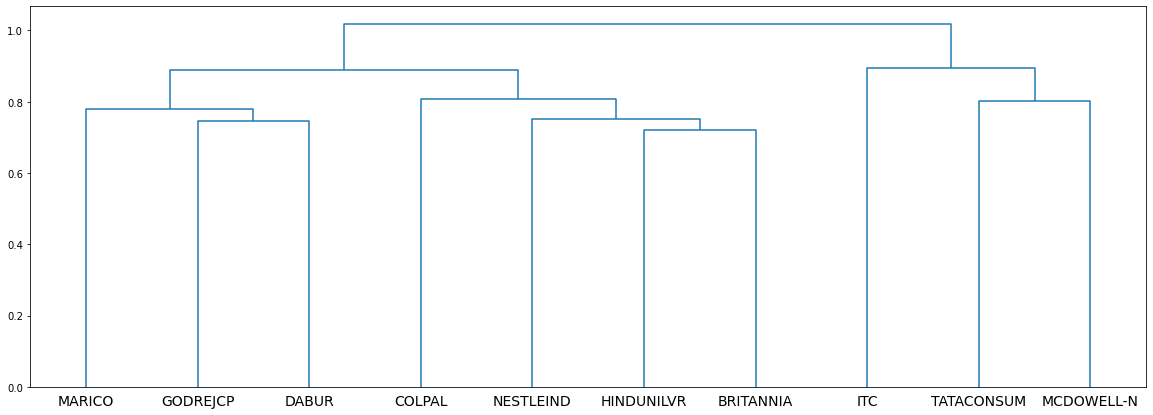

In [51]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

### 4.2 Steps involved in the HRP Model Design 

#### Quasi-Diagonalization and Weights Computation for HRP

Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [52]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [53]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [54]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [55]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [56]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                 MVP       HRP
HINDUNILVR  0.123348  0.085428
ITC         0.173914  0.125966
NESTLEIND   0.160059  0.126302
TATACONSUM  0.015067  0.074575
BRITANNIA   0.039296  0.066696
GODREJCP    0.023464  0.087020
DABUR       0.061136  0.111600
MCDOWELL-N  0.045178  0.077581
MARICO      0.146797  0.111558
COLPAL      0.211741  0.133274


Text(0.5, 1.0, 'HRP')

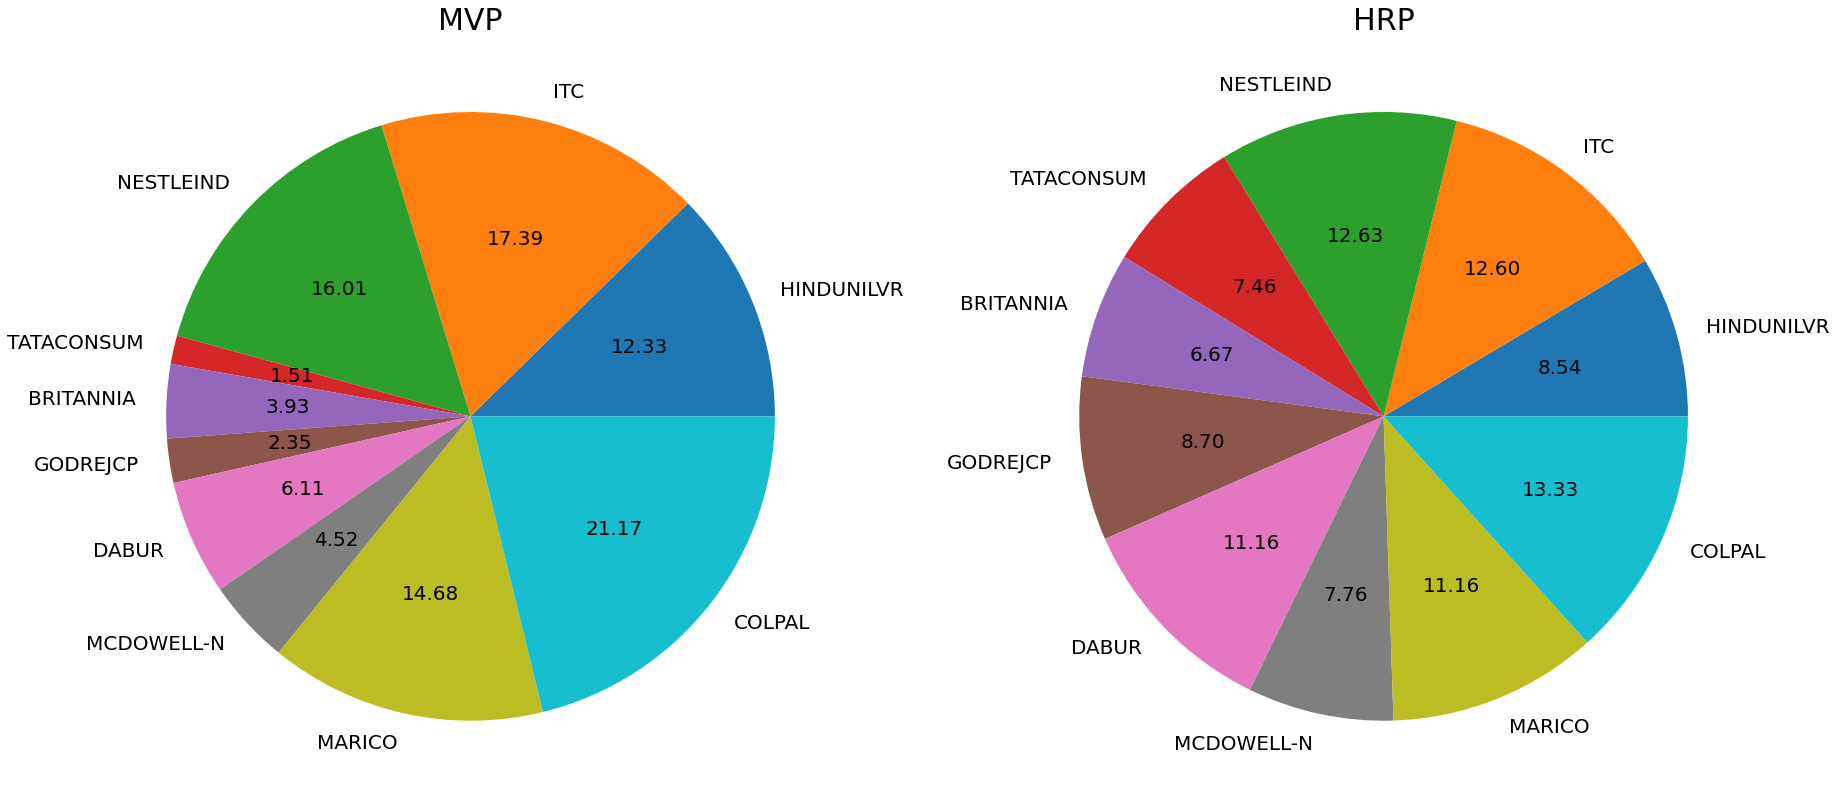

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [58]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

HINDUNILVR    0.123348
ITC           0.173914
NESTLEIND     0.160059
TATACONSUM    0.015067
BRITANNIA     0.039296
GODREJCP      0.023464
DABUR         0.061136
MCDOWELL-N    0.045178
MARICO        0.146797
COLPAL        0.211741
Name: MVP, dtype: float64

In [59]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

HINDUNILVR    0.085428
ITC           0.125966
NESTLEIND     0.126302
TATACONSUM    0.074575
BRITANNIA     0.066696
GODREJCP      0.087020
DABUR         0.111600
MCDOWELL-N    0.077581
MARICO        0.111558
COLPAL        0.133274
Name: HRP, dtype: float64

## 5. Performance Evaluation of the Portfolios 


### 5.1 Cumulative Returns - Training and Test Data 

In [60]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:xlabel='date', ylabel='Return'>

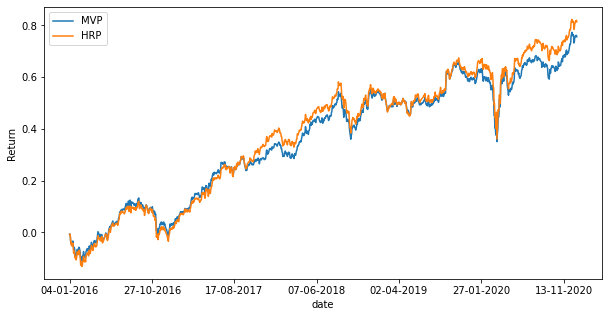

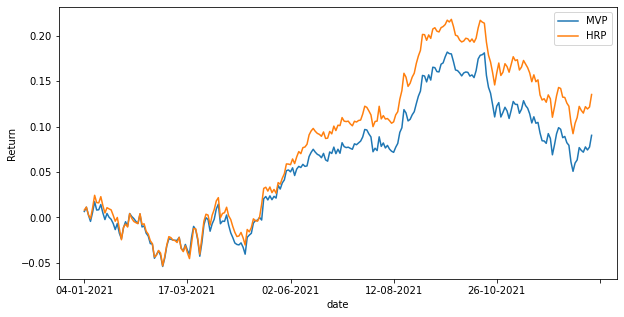

In [61]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [62]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.154491
HRP    0.166327
dtype: float64

In [63]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.092228
HRP    0.138124
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [64]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.163685     0.943831
HRP  0.168510     0.987048

In [65]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP   0.127075          0.72578
HRP   0.128036          1.07879